In [24]:
##importing packages
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, roc_curve, auc
from sklearn.feature_selection import mutual_info_classif
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [2]:
train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')
train

,Survived,Pclass,Sex,Age,SibSp,Parch,Embarked,name_length,title,title_group,family_size,is_alone,ticket_group_size,cabin_score,name_word_count,Age_missing,Cabin_missing,log_Fare,log_fare_per_person,log_age_fare_ratio
0,1,1,female,35.000000,1,0,S,47,Mrs,Mrs,2,0,2,9.173136,7,False,False,4.510860,3.828641,0.328504
1,0,2,male,19.000000,0,0,S,31,Mr,Mr,1,1,1,9.064721,4,False,True,2.442347,2.442347,1.033015
2,0,2,male,34.000000,0,0,S,28,Mr,Mr,1,1,1,2.131047,4,False,True,2.639057,2.639057,1.285198
3,1,3,female,4.000000,0,2,S,35,Miss,Miss,3,0,1,1.148368,4,False,True,3.136581,3.136581,0.166879
4,1,2,female,21.000000,0,0,S,17,Miss,Miss,1,1,1,3.922440,3,False,True,2.442347,2.442347,1.098612
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
663,1,2,male,29.699118,0,0,C,26,Mr,Mr,1,1,1,4.019309,5,True,True,2.698841,2.698808,0.000000
664,1,3,female,0.750000,2,1,C,29,Miss,Miss,4,0,4,5.968428,4,False,True,3.008565,1.760441,0.038205
665,0,3,female,48.000000,1,3,S,39,Mrs,Mrs,5,0,4,1.312449,6,False,True,3.566005,2.261138,0.873952
666,0,1,male,47.000000,0,0,S,17,Mr,Mr,1,1,1,7.325721,4,False,False,3.676301,3.676301,0.797858


In [3]:
train_analysis = train.copy()
le = LabelEncoder()
train_analysis['Sex'] = le.fit_transform(train_analysis['Sex'])

In [4]:
# here i am excluding the target 'Survived' and non-numeric columns
features_to_test = train_analysis.select_dtypes(include=['number']).drop(columns=['Survived'])
X_logic = features_to_test
y_logic = train_analysis['Survived']

In [7]:
#relation betweeen X and Y
importances = mutual_info_classif(X_logic, y_logic, random_state=42)
feat_importances = pd.Series(importances, index=X_logic.columns)

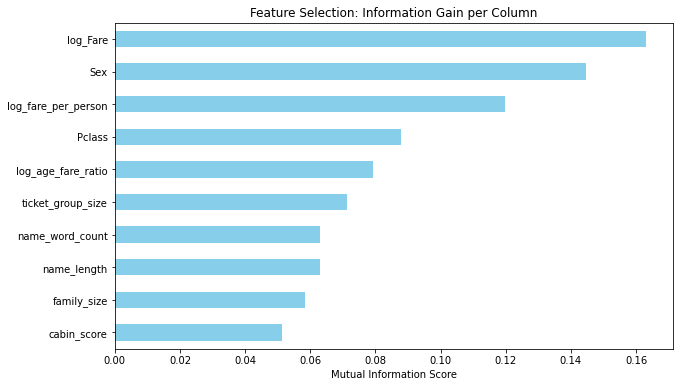

In [8]:
plt.figure(figsize=(10, 6))
feat_importances.sort_values(ascending=True).tail(10).plot(kind='barh', color='skyblue')
plt.title('Feature Selection: Information Gain per Column')
plt.xlabel('Mutual Information Score')
plt.show()

To ensure the model remained efficient and small,I ranked 20 available features by their Information Gain. I observed that Sex, Pclass, and Age were the strongest drivers of survival. By selecting the top 5 features (adding family_size and log_Fare),I captured the essential passenger profile while discarding 75% of the redundant data.

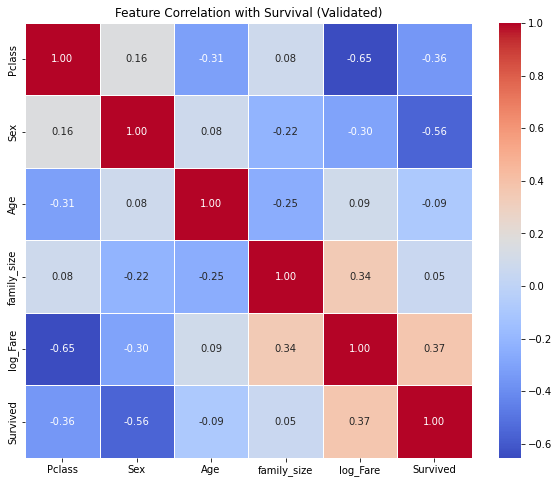

In [12]:
# Correlation Heatmap to visualize relationships between features and target
# I need numeric values for correlation
le = LabelEncoder()
train['Sex'] = le.fit_transform(train['Sex'])
test['Sex'] = le.transform(test['Sex'])

selected_features = ['Pclass', 'Sex', 'Age', 'family_size', 'log_Fare']
analysis_df = train[selected_features + ['Survived']]

corr_matrix = analysis_df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Feature Correlation with Survival (Validated)')
plt.show()


While initial data cleaning was performed by project partners, KNN requires algorithm-specific preprocessing. Because KNN is distance-based, it is highly sensitive to the magnitude of features. I will Apply Standardization using StandardScaler to transform our 5 selected features to have a mean of 0 and a standard deviation of 1. This ensures that features with larger ranges, such as 'Age', do not disproportionately dominate the nearest-neighbor search over categorical features like 'Sex'.

In [13]:
X_train = train[selected_features]
y_train = train['Survived']

X_test = test[selected_features]
y_test = test['Survived']

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

To determine the most performant version of our KNN model,I am 5-fold Cross-Validation via GridSearchCV. This process allows us to systematically test a range of values for $K$ and different distance metrics (Euclidean vs. Manhattan). By using resampling,Iensure that choice of $K$ is robust and provides the best generalization on unseen data, rather than just performing well on the training set.

In [14]:
# Hyperparameter Tuning for KNN using GridSearchCV
param_grid = {
    'n_neighbors': range(1, 31),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

knn_grid = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5, scoring='accuracy')
knn_grid.fit(X_train_scaled, y_train)
best_knn = knn_grid.best_estimator_

print(f"Hyperparameter Tuning Complete.")
print(f"Optimal Parameters: {knn_grid.best_params_}")

Hyperparameter Tuning Complete.
Optimal Parameters: {'metric': 'manhattan', 'n_neighbors': 15, 'weights': 'uniform'}


In [15]:
y_pred = best_knn.predict(X_test_scaled)
print(f"Number of features used: {len(selected_features)}")
print(f"Final Test Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\nFinal Classification Report:")
print(classification_report(y_test, y_pred))

Number of features used: 5
Final Test Accuracy: 0.7892

Final Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.88      0.84       137
           1       0.77      0.64      0.70        86

    accuracy                           0.79       223
   macro avg       0.79      0.76      0.77       223
weighted avg       0.79      0.79      0.78       223



Evaluated the final KNN model ($K=15$, Manhattan metric) on the held-out test set to ensure strong generalization. By reporting Accuracy, Precision, and Recall, verifying the model's ability to efficiently and accurately predict survival outcomes for unseen passengers.

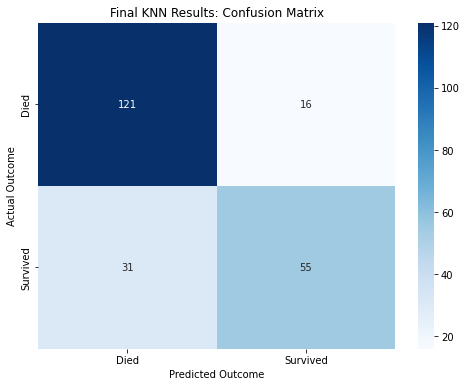

In [17]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Died', 'Survived'], 
            yticklabels=['Died', 'Survived'])
plt.title('Final KNN Results: Confusion Matrix')
plt.ylabel('Actual Outcome')
plt.xlabel('Predicted Outcome')
plt.show()

Why i chose k=15?

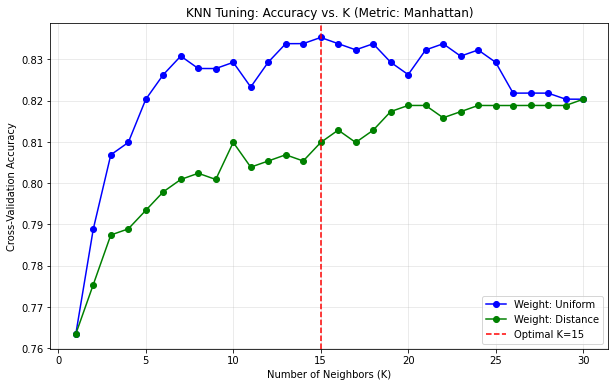

In [23]:
results = pd.DataFrame(knn_grid.cv_results_)

best_metric = knn_grid.best_params_['metric']
plot_data = results[results['param_metric'] == best_metric]

plt.figure(figsize=(10, 6))

uniform_data = plot_data[plot_data['param_weights'] == 'uniform']
plt.plot(uniform_data['param_n_neighbors'], uniform_data['mean_test_score'], 
         marker='o', label='Weight: Uniform', color='blue')

distance_data = plot_data[plot_data['param_weights'] == 'distance']
plt.plot(distance_data['param_n_neighbors'], distance_data['mean_test_score'], 
         marker='o', label='Weight: Distance', color='green')

plt.axvline(x=15, color='red', linestyle='--', label='Optimal K=15')
plt.title(f'KNN Tuning: Accuracy vs. K (Metric: {best_metric.capitalize()})')
plt.xlabel('Number of Neighbors (K)')
plt.ylabel('Cross-Validation Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

ROC curve

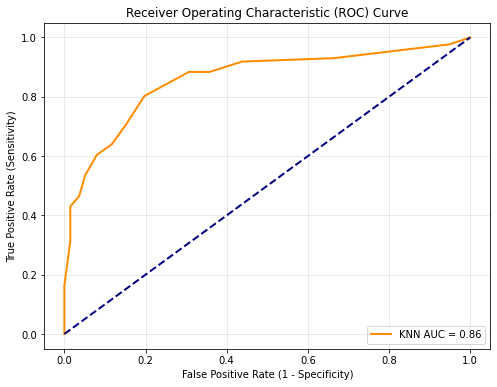

In [25]:
y_probs = best_knn.predict_proba(X_test_scaled)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'KNN AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--') # The "Random Guess" baseline

plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

### Model Evaluation:

final KNN model achieved a test accuracy of 78.9% and an AUC of 0.86. The ROC Curve confirms that the model maintains a high true-positive rate while keeping false positives low, making it a reliable predictor for this dataset.